In [1]:
!pip install transformers
!pip install emoji
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 16.4 MB/s eta 0:00:00


In [2]:
# Importar las librerías necesarias
import pandas as pd
import emoji
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset

In [3]:
# Cargar el dataset
df = pd.read_excel('dataset_final.xlsx')
print(f"Datos originales: {len(df)} comentarios")
display(df.head())  # Mostrar los primeros 5 registros

Datos originales: 2898 comentarios


,Comentario,Sentimiento
0,Le están dando el cartón de mentira para luego...,Neutro
1,ooowww!! Rose Leonor tu amiguis!! la alejitaa ...,Neutro
2,Felicidades primiis ♡♡,Positivo
3,Estamos aun paso para culminar nuestra Ingenie...,Positivo
4,Mijaaaaaaas Requelme Valdivieso,Neutro


In [4]:
# Eliminar filas con comentarios sin etiqueta asignada (etiqueta vacía)
df = df[df['Sentimiento'].notna()]
print(f"Después de eliminar comentarios sin etiqueta: {len(df)} comentarios")
display(df.head())

Después de eliminar comentarios sin etiqueta: 2685 comentarios


,Comentario,Sentimiento
0,Le están dando el cartón de mentira para luego...,Neutro
1,ooowww!! Rose Leonor tu amiguis!! la alejitaa ...,Neutro
2,Felicidades primiis ♡♡,Positivo
3,Estamos aun paso para culminar nuestra Ingenie...,Positivo
4,Mijaaaaaaas Requelme Valdivieso,Neutro


In [5]:
# Eliminar comentarios duplicados
df = df.drop_duplicates(subset='Comentario')
print(f"Después de eliminar duplicados: {len(df)} comentarios")
display(df.head())

Después de eliminar duplicados: 2588 comentarios


,Comentario,Sentimiento
0,Le están dando el cartón de mentira para luego...,Neutro
1,ooowww!! Rose Leonor tu amiguis!! la alejitaa ...,Neutro
2,Felicidades primiis ♡♡,Positivo
3,Estamos aun paso para culminar nuestra Ingenie...,Positivo
4,Mijaaaaaaas Requelme Valdivieso,Neutro


In [6]:
# Función para eliminar emojis de los comentarios
def eliminar_emojis(texto):
    return ''.join([char for char in texto if char not in emoji.EMOJI_DATA])

In [7]:
# Aplicar la función de eliminar emojis a la columna 'Comentarios'
df['Comentario'] = df['Comentario'].apply(eliminar_emojis)
print(f"Después de eliminar emojis: {len(df)} comentarios")
display(df.head())


Después de eliminar emojis: 2588 comentarios


,Comentario,Sentimiento
0,Le están dando el cartón de mentira para luego...,Neutro
1,ooowww!! Rose Leonor tu amiguis!! la alejitaa ...,Neutro
2,Felicidades primiis ♡♡,Positivo
3,Estamos aun paso para culminar nuestra Ingenie...,Positivo
4,Mijaaaaaaas Requelme Valdivieso,Neutro


TOKENIZAR COMENTARIOS

In [8]:
# Codificar las etiquetas
sentimiento_map = {'Positivo': 1, 'Negativo': 0, 'Neutro': 2}
# Mapear valores y manejar nulos reemplazándolos con un valor predeterminado o eliminándolos
df['Sentimiento_Id'] = df['Sentimiento'].map(sentimiento_map)

# Eliminar filas con valores nulos resultantes del mapeo
df = df[df['Sentimiento_Id'].notna()]

# Convertir a enteros después de manejar los nulos
df['Sentimiento_Id'] = df['Sentimiento_Id'].astype(int)


In [9]:
# Dividir los datos en entrenamiento y prueba
X = df['Comentario'].tolist()
y = df['Sentimiento_Id'].tolist()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# Tokenización con WordPiece usando el tokenizador de BETO
# Cargar el tokenizador de BETO
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

In [11]:
# Crear un Dataset compatible con PyTorch
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Asegurar tipo correcto
        return {key: torch.tensor(value) for key, value in item.items()}

In [12]:
# Tokenizar los datos
def tokenize_data(data, labels):
    encodings = tokenizer(data, truncation=True, padding=True, max_length=128, return_tensors="pt")
    return SentimentDataset(encodings, labels)

train_dataset = tokenize_data(X_train, y_train)
val_dataset = tokenize_data(X_val, y_val)

PREPARACIÓN DEL MODELO

In [13]:
# Configurar el modelo
model = BertForSequenceClassification.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-cased',
    num_labels=3  # Positivo, Negativo, Neutral
)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Configurar los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',         # Carpeta para los resultados
    eval_strategy='epoch',   # Evaluar al final de cada época
    learning_rate=2e-5,            # Tasa de aprendizaje
    per_device_train_batch_size=16, # Tamaño del lote de entrenamiento
    per_device_eval_batch_size=16,  # Tamaño del lote de validación
    num_train_epochs=8,            # Número de épocas
    weight_decay=0.01,             # Decaimiento del peso
    logging_dir='./logs',          # Carpeta para los logs
    logging_steps=10,
    save_strategy='epoch',         # Guardar el modelo al final de cada época
)

In [15]:
# Crear el entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [16]:
# Entrenar el modelo
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cristhophervillamarin7 (cristhophervillamarin7-espe) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


<ipython-input-11-3762412821>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(value) for key, value in item.items()}


Epoch,Training Loss,Validation Loss
1,0.357000,0.378591
2,0.229200,0.371899
3,0.092800,0.559949
4,0.019400,0.737073
5,0.032400,0.816444
6,0.000500,0.856011
7,0.000500,0.865393
8,0.000400,0.865480


<ipython-input-11-3762412821>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(value) for key, value in item.items()}
<ipython-input-11-3762412821>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(value) for key, value in item.items()}
<ipython-input-11-3762412821>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(value) for key, value in item.items()}
<ipython-input-11-3762412821>:13: UserWarning: To copy construct from a tensor, it is recommended to use sour

TrainOutput(global_step=1040, training_loss=0.11130548006845996, metrics={'train_runtime': 530.1547, 'train_samples_per_second': 31.221, 'train_steps_per_second': 1.962, 'total_flos': 1088763322558464.0, 'train_loss': 0.11130548006845996, 'epoch': 8.0})

In [17]:
# Sección de graficar la matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

# Función para graficar la matriz de confusión
def graficar_matriz_de_confusion(y_true, y_pred, etiquetas):
    matriz_confusion = confusion_matrix(y_true, y_pred, labels=list(set(y_true)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        matriz_confusion,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=etiquetas,
        yticklabels=etiquetas
    )
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores Reales")
    plt.show()


EVALUACIÓN DEL MODELO

<ipython-input-11-3762412821>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(value) for key, value in item.items()}


              precision    recall  f1-score   support

    Negativo       0.82      0.92      0.87        63
    Positivo       0.96      0.93      0.95       106
      Neutro       0.91      0.86      0.88        90

    accuracy                           0.90       259
   macro avg       0.89      0.90      0.90       259
weighted avg       0.91      0.90      0.90       259

[[58  1  4]
 [ 3 99  4]
 [10  3 77]]


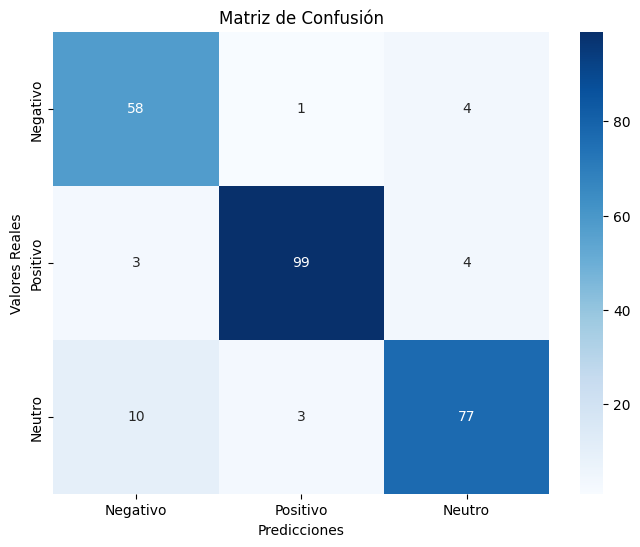

In [18]:
def evaluate_model(trainer, X_test, y_test):
    test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128, return_tensors='pt')
    test_dataset = SentimentDataset(test_encodings, y_test)
    predictions = trainer.predict(test_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    # Add labels parameter to match the unique classes in y_test
    print(classification_report(y_test, preds, labels=list(set(y_test)), target_names=['Negativo', 'Positivo', 'Neutro']))
    print(confusion_matrix(y_test, preds))
    graficar_matriz_de_confusion(y_test, preds, etiquetas=['Negativo', 'Positivo', 'Neutro'])


evaluate_model(trainer, X_test, y_test)


In [30]:
# Función para predecir el sentimiento de un comentario
def predecir_sentimiento(comentario, model, tokenizer):
    # Configurar el dispositivo (GPU si está disponible, de lo contrario CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Mover el modelo al dispositivo

    # Tokenizar el comentario y mover los datos al dispositivo
    inputs = tokenizer(comentario, truncation=True, padding=True, max_length=128, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Mover tensores al dispositivo

    # Hacer la predicción con el modelo entrenado
    outputs = model(**inputs)

    # Calcular las probabilidades y predecir la clase
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred = torch.argmax(probs, dim=1).item()

    # Mapear la predicción a la etiqueta correspondiente
    etiquetas = {0: "Negativo", 1: "Positivo", 2: "Neutro"}
    sentimiento = etiquetas[pred]

    return sentimiento

# Ejemplo de uso
comentario = "Felicitaciones"
resultado = predecir_sentimiento(comentario, model, tokenizer)
print(f"El sentimiento del comentario es: {resultado}")

El sentimiento del comentario es: Positivo


In [20]:
import torch
import pickle
from transformers import BertTokenizer, BertForSequenceClassification

# Asegurarse de que el modelo esté en CPU antes de guardarlo
model = model.cpu()

# Guardar el modelo y el tokenizador en CPU
with open("modelo_y_tokenizador.pkl", "wb") as f:
    pickle.dump((model, tokenizer), f)

# Verificar que se guardó correctamente
with open("modelo_y_tokenizador.pkl", "rb") as f:
    model_loaded, tokenizer_loaded = pickle.load(f)

# Probar el modelo cargado
comentario = "Me alegro por ti, excelente trabajo"
resultado = predecir_sentimiento(comentario, model_loaded, tokenizer_loaded)
print(f"El sentimiento del comentario es: {resultado}")

El sentimiento del comentario es: Positivo
